# Redes Neuronales Recurrentes (RNN)

Vamos a ver aquí como usar las redes neuronales recurrentes en keras.

In [1]:
%load_ext watermark
%watermark

2019-04-10T03:15:35-05:00

CPython 3.7.3rc1
IPython 7.3.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [31]:
from IPython.display import Image


import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 7)

### Ejemplo 1: Análisis de sentimiento en texto

Las RNN funciona de forma particularmente bien a la hora de tratar con texto, ya que por definición el texto es una secuencia ordenada de palabras, y las RNN están especializadas en información secuencial.

En este ejemplo vamos a hacer un modelo que haga **Análisis de Sentimiento**. Estos análisis consisten en dado un texto, predecir si el texto es un texto con tono positivo o negativo.

Para ello vamos a usar un dataset de entrenamiento creado por la Sociedad Española del Procesado de Lenguaje Natural (SEPLN), y que usan en una conferencia llamada TASS (Taller de Análisis Semántico en la SEPLN).

No puedo compartirlo pero se puede solicitar acceso a los corpus tras firmar la licencia de uso [aquí](http://www.sepln.org/workshops/tass/tass_data/download.php). Luego se pueden modificar dichos corpus mediante el código que explico [aquí](https://github.com/manugarri/tweets_map/blob/master/4.%20Sentiment%20Analysis.ipynb)

### Cargamos los datos

In [3]:
import pandas as pd
pd.set_option('max_colwidth',1000)

In [6]:
tweets_corpus = pd.read_csv("D:/datasets/Kaggle/Jigsaw Unintended Bias in Toxicity Classification/train.csv")

In [7]:
tweets_corpus.head(10)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
1,59849,0.000000,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
2,59852,0.000000,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
3,59855,0.000000,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.000000,4,47
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.009524,0,105
6,59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.220339,0,59
7,59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
8,239575,0.000000,The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,26662,approved,0,0,0,0,0,0.000000,0,4
9,239576,0.000000,It was a great show. Not a combo I'd of expected to be good together but it was.,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,26650,approved,0,0,0,1,0,0.000000,0,4


In [87]:
tweets_corpus.shape

(72073, 3)

In [88]:
tweets_corpus.polarity.value_counts()

NONE    22898
P+      22397
N       14200
N+       5404
P        4230
NEU      2944
Name: polarity, dtype: int64

In [89]:
polaridades = pd.get_dummies(tweets_corpus.polarity)
polaridades.head()

,N,N+,NEU,NONE,P,P+
0,1,0,0,0,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,0,0,1


In [90]:
polaridades_one_hot = polaridades.values
polaridades_one_hot[:5]

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [91]:
polaridades_dict = dict(zip(range(7), polaridades.columns))
polaridades_dict

{0: 'N', 1: 'N+', 2: 'NEU', 3: 'NONE', 4: 'P', 5: 'P+'}

### Procesamos el texto

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Vamos a tokenizar los tweets. Vamos a convertirlos en vectores de números, donde cada número representa una palabra. Usaremos las 1500 palabrás más comunes en el dataset

In [92]:
max_palabras = 1500
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(tweets_corpus.content.values)
X = tokenizer.texts_to_sequences(tweets_corpus.content.values)
X = pad_sequences(X)

In [93]:
X.shape

(72073, 43)

In [94]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  231, 1268,   15,   35,  112,    5,  963,
          6,  524,    3,  825,  701,   53,  511, 1332,   15,  551])

Vemos que el tweet más largo tiene 43 palabras.

In [95]:
tokenizer.word_index

{'de': 1,
 'la': 2,
 'el': 3,
 'en': 4,
 'a': 5,
 'y': 6,
 't': 7,
 'co': 8,
 'http': 9,
 'que': 10,
 'los': 11,
 'no': 12,
 'del': 13,
 'es': 14,
 'con': 15,
 'un': 16,
 'para': 17,
 'las': 18,
 'se': 19,
 'por': 20,
 'lo': 21,
 'al': 22,
 'una': 23,
 'q': 24,
 'rt': 25,
 'me': 26,
 '“': 27,
 'hoy': 28,
 'ha': 29,
 'su': 30,
 'd': 31,
 'como': 32,
 'si': 33,
 'más': 34,
 'rajoy': 35,
 'mi': 36,
 'ya': 37,
 'pero': 38,
 'pp': 39,
 'sobre': 40,
 'gracias': 41,
 'esta': 42,
 'todos': 43,
 'gobierno': 44,
 'madrid': 45,
 'psoe': 46,
 'le': 47,
 'hay': 48,
 'o': 49,
 'mañana': 50,
 'ahora': 51,
 'muy': 52,
 'nos': 53,
 'vía': 54,
 'sin': 55,
 'os': 56,
 'españa': 57,
 'mas': 58,
 'día': 59,
 'días': 60,
 'está': 61,
 '”': 62,
 'qué': 63,
 'ser': 64,
 'te': 65,
 'todo': 66,
 'este': 67,
 'dice': 68,
 'yo': 69,
 'congreso': 70,
 '30': 71,
 'son': 72,
 '20': 73,
 'gran': 74,
 'buenos': 75,
 'sus': 76,
 'mejor': 77,
 'rubalcaba': 78,
 'han': 79,
 'ni': 80,
 'ver': 81,
 'desde': 82,
 'tiene': 8

Podemos crear un mapa inverso de la lista de palabras, esto nos permite reconstruir un tweet en función de su versión vectorizada

In [96]:
mapa_inverso = dict(map(reversed, tokenizer.word_index.items()))

In [97]:
mapa_inverso

{1: 'de',
 2: 'la',
 3: 'el',
 4: 'en',
 5: 'a',
 6: 'y',
 7: 't',
 8: 'co',
 9: 'http',
 10: 'que',
 11: 'los',
 12: 'no',
 13: 'del',
 14: 'es',
 15: 'con',
 16: 'un',
 17: 'para',
 18: 'las',
 19: 'se',
 20: 'por',
 21: 'lo',
 22: 'al',
 23: 'una',
 24: 'q',
 25: 'rt',
 26: 'me',
 27: '“',
 28: 'hoy',
 29: 'ha',
 30: 'su',
 31: 'd',
 32: 'como',
 33: 'si',
 34: 'más',
 35: 'rajoy',
 36: 'mi',
 37: 'ya',
 38: 'pero',
 39: 'pp',
 40: 'sobre',
 41: 'gracias',
 42: 'esta',
 43: 'todos',
 44: 'gobierno',
 45: 'madrid',
 46: 'psoe',
 47: 'le',
 48: 'hay',
 49: 'o',
 50: 'mañana',
 51: 'ahora',
 52: 'muy',
 53: 'nos',
 54: 'vía',
 55: 'sin',
 56: 'os',
 57: 'españa',
 58: 'mas',
 59: 'día',
 60: 'días',
 61: 'está',
 62: '”',
 63: 'qué',
 64: 'ser',
 65: 'te',
 66: 'todo',
 67: 'este',
 68: 'dice',
 69: 'yo',
 70: 'congreso',
 71: '30',
 72: 'son',
 73: '20',
 74: 'gran',
 75: 'buenos',
 76: 'sus',
 77: 'mejor',
 78: 'rubalcaba',
 79: 'han',
 80: 'ni',
 81: 'ver',
 82: 'desde',
 83: 'tiene

Así si tomamos el primer tweet

In [98]:
tweets_corpus.content.values[0]

'Primer viaje con Rajoy presidente a Maruecos. Austeridad y mano tendida. El próximo miércoles nos espera Berlín. Cita con Merkel'

Vemos su versión vectorizada:

In [99]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  231, 1268,   15,   35,  112,    5,  963,
          6,  524,    3,  825,  701,   53,  511, 1332,   15,  551])

Podemos reconstruirlo con el mapa_inverso del tokenizador

In [101]:
[mapa_inverso[i] for i in X[0] if i in mapa_inverso]

['primer',
 'viaje',
 'con',
 'rajoy',
 'presidente',
 'a',
 'austeridad',
 'y',
 'mano',
 'el',
 'próximo',
 'miércoles',
 'nos',
 'espera',
 'cita',
 'con',
 'merkel']

### Creamos la RNN

Como capa de entrada vamos a usar la capa [`Embedding`](https://keras.io/layers/embeddings/). Es una capa que se encarga de transformar una matriz de texto (donde cada número representa una palabra), en una matriz que representa las relaciones entre las frases  en función de sus palabras.

Digamos que un Embedding (word embedding) es una forma mejor de representar texto (captura mejor la información).

In [20]:
from keras import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU

numero_clases = 6

modelo_sentimiento = Sequential()
modelo_sentimiento.add(Embedding(max_palabras, 128, input_length=X.shape[1]))
modelo_sentimiento.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
modelo_sentimiento.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))

modelo_sentimiento.add(Dense(numero_clases, activation='softmax'))

Using TensorFlow backend.


KeyboardInterrupt: 

In [135]:
modelo_sentimiento.compile(loss = 'categorical_crossentropy', optimizer='adam',
                           metrics = ['accuracy'])
print(modelo_sentimiento.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 43, 128)           192000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 43, 256)           394240    
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 1542      
Total params: 1,113,094
Trainable params: 1,113,094
Non-trainable params: 0
_________________________________________________________________
None


In [136]:
from sklearn.model_selection import train_test_split

Y = polaridades_one_hot
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)

In [137]:
from keras.callbacks import EarlyStopping
batch_size = 256
early_stop = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5, verbose=1)
modelo_sentimiento.fit(X_train, Y_train, epochs=100, batch_size=batch_size, verbose=1,
                      callbacks=[early_stop]);

Epoch 1/100
57658/57658 [==============================] - 67s 1ms/step - loss: 1.2656 - acc: 0.5008
Epoch 2/100
57658/57658 [==============================] - 66s 1ms/step - loss: 1.0365 - acc: 0.6168
Epoch 3/100
57658/57658 [==============================] - 71s 1ms/step - loss: 0.9913 - acc: 0.6315
Epoch 4/100
57658/57658 [==============================] - 65s 1ms/step - loss: 0.9694 - acc: 0.6396
Epoch 5/100
57658/57658 [==============================] - 78s 1ms/step - loss: 0.9579 - acc: 0.6431
Epoch 6/100
57658/57658 [==============================] - 79s 1ms/step - loss: 0.9501 - acc: 0.6434
Epoch 7/100
57658/57658 [==============================] - 78s 1ms/step - loss: 0.9345 - acc: 0.6506
Epoch 8/100
57658/57658 [==============================] - 95s 2ms/step - loss: 0.9264 - acc: 0.6525
Epoch 9/100
57658/57658 [==============================] - 98s 2ms/step - loss: 0.9147 - acc: 0.6568
Epoch 10/100
57658/57658 [==============================] - 91s 2ms/step - loss: 0.9062 - a

57658/57658 [==============================] - 28s 480us/step - loss: 0.1827 - acc: 0.9333
Epoch 81/100
57658/57658 [==============================] - 28s 482us/step - loss: 0.1771 - acc: 0.9370
Epoch 82/100
57658/57658 [==============================] - 28s 483us/step - loss: 0.1740 - acc: 0.9380
Epoch 83/100
57658/57658 [==============================] - 28s 480us/step - loss: 0.1710 - acc: 0.9397
Epoch 84/100
57658/57658 [==============================] - 28s 485us/step - loss: 0.1698 - acc: 0.9400
Epoch 85/100
57658/57658 [==============================] - 28s 485us/step - loss: 0.1698 - acc: 0.9399
Epoch 86/100
57658/57658 [==============================] - 28s 481us/step - loss: 0.1648 - acc: 0.9420
Epoch 87/100
57658/57658 [==============================] - 28s 486us/step - loss: 0.1618 - acc: 0.9430
Epoch 88/100
57658/57658 [==============================] - 28s 482us/step - loss: 0.1630 - acc: 0.9415
Epoch 89/100
57658/57658 [==============================] - 28s 485us/step - 

Ahora evaluamos con los datos de test

In [138]:
loss, precision_test = modelo_sentimiento.evaluate(X_test, Y_test)
precision_test

14415/14415 [==============================] - 14s 944us/step


0.5653832813331413

Ahora podemos tomar una nueva frase y predecir su polaridad

In [105]:
nueva_frase = "Que bonito es el amor"

In [106]:
nueva_frase_tokenizada = tokenizer.texts_to_sequences([nueva_frase])
nueva_frase_tokenizada_pad = pad_sequences(nueva_frase_tokenizada, maxlen=43)

In [107]:
nueva_frase_tokenizada

[[10, 1376, 14, 3, 775]]

In [108]:
nueva_frase_tokenizada_pad

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   10, 1376,   14,    3,  775]])

In [109]:
modelo_sentimiento.predict_classes(nueva_frase_tokenizada_pad)

array([0], dtype=int64)

In [110]:
polaridades_dict[0]

'N'

### Series Temporales 

Vamos a usar un dataset que contiene el número de pasajeros de avión internacionales por mes, obtenido de [este link](https://www.kaggle.com/andreazzini/international-airline-passengers).

En concreto vamos a intentar predecir el número de pasajeros de líneas aereas los últimos meses del dataset.

### Cargamos los datos

In [8]:
import pandas as pd

pasajeros = pd.read_csv('D:/datasets/Curso_Mauel_Garrido/international-airline-passengers.csv',
                        sep=";")
pasajeros.columns = ["mes", "pasajeros"]

In [9]:
pasajeros.head()

,mes,pasajeros
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


La variable objetivo de este modelo será predecir el volumen de pasajeros del mes siguiente. Podemos usar la función de pandas `shift` para mover la columna del número de pasajeros una posición hacia arriba.

In [10]:
pasajeros["pasajeros_1"] = pasajeros["pasajeros"].shift(-1)

In [11]:
pasajeros.tail()

,mes,pasajeros,pasajeros_1
139,1960-08,606,508.0
140,1960-09,508,461.0
141,1960-10,461,390.0
142,1960-11,390,432.0
143,1960-12,432,NaN


Al hacer esto la última fila no tiene un valor para predecir, la eliminamos.

In [12]:
pasajeros = pasajeros.drop(143)

In [13]:
pasajeros_x = pasajeros["pasajeros"].astype(float).values
pasajeros_y = pasajeros["pasajeros_1"].astype(float).values

In [14]:
n_periodos = len(pasajeros)
pct_test = 0.2

n_train = int(n_periodos * (1-pct_test))
n_train

114

Como siempre, estandarizamos los datos

In [15]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaler.fit(pasajeros_x.reshape(-1, 1))

pasajeros_x_std = scaler.transform(pasajeros_x.reshape(-1, 1))
pasajeros_y_std = scaler.transform(pasajeros_y.reshape(-1, 1))

In [16]:
x_train = pasajeros_x_std[:n_train]
x_test = pasajeros_x_std[n_train:]

y_train = pasajeros_y_std[:n_train]
y_test = pasajeros_y_std[n_train:]

In [17]:
x_train = x_train.reshape(-1,1,1)
x_test = x_test.reshape(-1,1,1)

In [18]:
x_train.shape

(114, 1, 1)

In [23]:
from keras import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU

modelo_lstm = Sequential()
modelo_lstm.add(GRU(10, input_shape=(1, 1)))
modelo_lstm.add(Dense(1))
modelo_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 10)                360       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


In [24]:
modelo_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
modelo_lstm.fit(x_train, y_train, epochs=100, batch_size=1, verbose=1);

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
114/114 [==============================] - 3s 23ms/step - loss: 0.5778 - mean_squared_error: 0.5778
Epoch 2/100
114/114 [==============================] - 0s 2ms/step - loss: 0.3538 - mean_squared_error: 0.3538
Epoch 3/100
114/114 [==============================] - 0s 1ms/step - loss: 0.1869 - mean_squared_error: 0.1869
Epoch 4/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0999 - mean_squared_error: 0.0999
Epoch 5/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0665 - mean_squared_error: 0.0665
Epoch 6/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0552 - mean_squared_error: 0.0552
Epoch 7/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0525 - mean_squared_error: 0.0525
Epoch 8/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0515 - mean_squared_error: 0.0515
Epoch 9/100
114/114 [==============================] - 0s 2ms/s

114/114 [==============================] - 0s 1ms/step - loss: 0.0504 - mean_squared_error: 0.0504
Epoch 72/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0510 - mean_squared_error: 0.0510
Epoch 73/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0505 - mean_squared_error: 0.0505
Epoch 74/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0512 - mean_squared_error: 0.0512
Epoch 75/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0505 - mean_squared_error: 0.0505
Epoch 76/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 77/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0507 - mean_squared_error: 0.0507
Epoch 78/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0508 - mean_squared_error: 0.0508
Epoch 79/100
114/114 [==============================] - 0s 1ms/step - loss: 0.0509 - mean_squared_error: 0.0509
Epoch

In [25]:
from sklearn.metrics import mean_squared_error
train_pred = scaler.inverse_transform(modelo_lstm.predict(x_train))
y_train_original = scaler.inverse_transform(y_train)
error_train = np.sqrt(mean_squared_error(y_train_original, train_pred))

error_train

26.591664561675984

In [26]:
from sklearn.metrics import mean_squared_error

test_pred = scaler.inverse_transform(modelo_lstm.predict(x_test))
y_test_original = scaler.inverse_transform(y_test)
error_test = np.sqrt(mean_squared_error(y_test_original, test_pred))

error_test

54.486084405964306

In [27]:
test_pred.shape

(29, 1)

In [28]:
test_pred_plot = np.zeros(pasajeros_y.shape)
test_pred_plot[-test_pred.shape[0]:] = test_pred[:,0]

test_pred_plot[:-test_pred.shape[0]] = np.nan

In [29]:
test_pred_plot

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

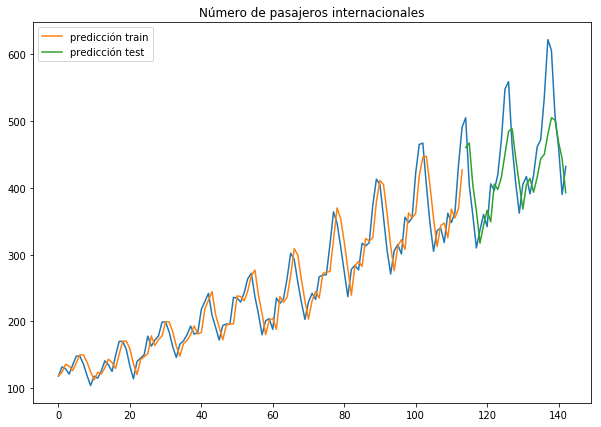

In [32]:
plt.plot(pasajeros_y)
plt.plot(train_pred, label="predicción train")
plt.plot(test_pred_plot, label="predicción test")
plt.title("Número de pasajeros internacionales")
plt.legend();